[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jussippjokinen/CogMod-Tutorial/blob/main/02-DeepRL/Gaze_Based_Interaction/gaze_based_interaction.ipynb)


# A cognitive model of gaze-based interaction

Some cognitive models describe behaviour and others predict it. Models that predict behaviour must be capable of generating output without that output being part of the input. In this notebook we demonstrate this property for a model of eye movements. The model is a reinforcement learner that is trained by performing hundreds of thousands of simulated eye movements in search of a target of varying size and distance. The model predicts how many eye movements people will tend to make to find a target of a given size and distance. It predicts inhibition of return. It **predicts** Fitts's Law like behaviour and it predicts that the first eye movement will usually undershoot, rather than overshoot the target.

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/03-Reinforcement-Learning/034_Gaze_based_Interaction/image/sub_movements.png" alt="Corati Modeling" width="400">

(source: Meyer, D. E., Abrams, R. A., Kornblum, S., Wright, C. E., & Keith Smith, J. E. (1988). Optimality in human motor performance: ideal control of rapid aimed movements. Psychological review, 95(3), 340.)

Note that what might seem the obvious strategy -- aim for where you believe the target is -- is not necessarily the optimal strategy.

### The task: Gaze-based interaction

Gaze-based interaction is a mode of interaction in which users, including users with a range of movement disabilities, are able to indicate which display item they wish to select by fixating their eyes on it. Confirmation of selection is then made with one of a number of methods, including with a key press, or by holding the fixation for an extended duration of time. The model performs this task for targets with randomly selected location and size.

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/03-Reinforcement-Learning/034_Gaze_based_Interaction/image/gaze_task.png" alt="Corati Modeling" width="400">

In the figure, the red lines represent saccades (eye movements). Multiple eye movements are needed to reach the target (the black circle).

### Model architecture

The model has a simple architecture that you have previously seen in the introduction. The figure is reproduced here:

<img src="https://raw.githubusercontent.com/howesa/CHI22-CogMod-Tutorial/main/03-Reinforcement-Learning/034_Gaze_based_Interaction/image/cog_arch.png" alt="Corati Modeling" width="700">

- The **control** module makes decisions about where to move the eyes with the oculomotor system. Decisions are conditioned on the current belief about the location of the target.
- The **motor** module implements decisions but it is bounded by Gaussian noise, which models noise in the human motor system.
- The **environment** models the physics of the world and the task (the location of the target). Given a response from the motor system, a saccade is made to the aim point of the eyes, and a fixation is initiated.
- The **perception** module simulates the human capacity to localize a target with foveated vision. The accuracy of the location estimate generated by perception is negatively affected by the eccentricity of the target from the current fixation location.
- The **Memory** module stores a representation of the current state. Over the course of an episode a sequence of location estimates will be made. Humans are known to integrate these estimates into a single integrated representation of the location. People are known to do this optimally using a process that can be modelled with Bayesian state estimation. The state estimation constitutes a belief about the location of the target.
- The **Utility** module calculates a reward signal given the current belief about the enviornment. The reward signal is used to train the controller.

### Prerequisites

Before proceeding with this notebook you should firrst review the notebooks on foveated vision and on Bayesian integration. These explain how the perception and memory modules work.



### Machine learning

In order to learn how to perform the task, the model uses implementations of reinforcement learning algorithms in PyTorch known as stable-baselines3.

In [14]:
# Install stable_baselines3 and the gymnasium environment
# This is a well known machine learning library that provides a suite of reinforcement learning methods.
# Only needs to be run once

!pip install --pre -U stable_baselines3

import gymnasium as gym
from gymnasium import spaces

In [15]:
# Load local modules
# gazetools is a module that contains support functions for modeling gaze-based interaction.
# the code below makes use of them but we do not need to understand how they work in this tutorial.

!wget https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/02-DeepRL/Gaze_Based_Interaction/gazetools.py

import gazetools

--2025-11-02 21:42:00--  https://raw.githubusercontent.com/jussippjokinen/CogMod-Tutorial/main/02-DeepRL/Gaze_Based_Interaction/gazetools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5204 (5.1K) [text/plain]
Saving to: ‘gazetools.py.1’

gazetools.py.1      100%[===================>]   5.08K  --.-KB/s    in 0s      

2025-11-02 21:42:00 (75.6 MB/s) - ‘gazetools.py.1’ saved [5204/5204]



In [32]:
# load required standard modules and configure matplotlib

import numpy as np
import math
import matplotlib.pyplot as plt
import sys

import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Implementation of the Cognitive Architecture as a Python Class

The first step to formalise the model architecture presented in the above figure. We do this by specifying a class of cognitive theories and will later define an instance of this class.

The class has only a single method, which defines a cycle through the processes defined in the figure.

In [17]:
class CognitivePOMDP():

    def __init__(self):
        self.internal_state = {}

    def step(self, ext, action):
        ''' Define the cognitive architecture.'''
        self._update_state_with_action(action)
        response = self._get_response()
        external_state, done = ext.external_env(response)
        stimulus, stimulus_std = self._get_stimulus(ext.external_state)
        self._update_state_with_stimulus(stimulus, stimulus_std)
        obs = self._get_obs()
        reward = self._get_reward()
        return obs, reward, done

### A theory of gaze-based interaction

Each of the entities in the cognitive architecture must be defined so as to make explicit our theory of gaze-based interaction. The theory makes the following assumptions:

- The perception of the target location is corrupted by Gaussian noise in human vision.
- The standard deviation of noise increases linearly with eccentricity from the fovea.
- Sequences of stimuli are noisily perceived and optimally integrated.
- Intended eye movements (oculomotor actions) are corrupted by signal dependent Gaussian noise to generate responses.

These assumptions are further described in Chen et al. (2021).

In [38]:
class GazeTheory(CognitivePOMDP):

    def __init__(self,
                 oculomotor_noise_weight: float = 0.01,
                 stimulus_noise_weight:  float = 0.09,
                 step_cost: float        = -1.0,
                 # time parameters
                 saccade_speed: float    = 20.0,   # units/sec
                 fixation_mean: float    = 0.25,   # s
                 fixation_sd:   float    = 0.05,  # s
                 dwell_on_hit:  float    = 0.30):  # s
        super().__init__()
        self.oculomotor_noise_weight = oculomotor_noise_weight
        self.stimulus_noise_weight  = stimulus_noise_weight
        self.step_cost   = step_cost
        self.saccade_speed = saccade_speed
        self.fixation_mean = fixation_mean
        self.fixation_sd  = fixation_sd
        self.dwell_on_hit  = dwell_on_hit

    def reset_internal_env(self, external_state):
        self.internal_state = {
            'fixation'   : np.array([-1.0, -1.0], dtype=np.float32),
            'target'    : np.array([ 0.0,  0.0], dtype=np.float32),
            'target_std'  : np.float32(0.1),
            'width'    : float(external_state['width']),
            'action'    : np.array([-1.0, -1.0], dtype=np.float32),
            'time_last_step': 0.0,
            'time_total'  : 0.0,
        }
        return self._get_obs()

    def _update_state_with_action(self, action):
        self.internal_state['action'] = np.clip(np.asarray(action, dtype=np.float32), -1.0, 1.0)

    def _get_response(self):
        fix = self.internal_state['fixation']
        aim = self.internal_state['action']
        move_distance = float(gazetools.get_distance(fix, aim))

        # signal-dependent motor noise
        sigma = self.oculomotor_noise_weight * move_distance
        motor_noise = np.random.normal(0.0, sigma, size=2).astype(np.float32)

        resp = np.clip(aim + motor_noise, -1.0, 1.0)

        # time for this step = fixation + saccade
        saccade_time  = move_distance / max(1e-6, self.saccade_speed)
        fixation_time = float(np.clip(np.random.normal(self.fixation_mean, self.fixation_sd), 0.05, None))
        step_time = saccade_time + fixation_time

        self.internal_state['fixation']       = resp
        self.internal_state['time_last_step'] = step_time
        self.internal_state['time_total']    += step_time
        return resp

    def _get_stimulus(self, external_state):
        # foveated sensing: noise grows with eccentricity
        fix = external_state.get('fixation', self.internal_state['fixation'])
        eccentricity = float(gazetools.get_distance(external_state['target'], fix))
        stm_std = max(1e-6, self.stimulus_noise_weight * eccentricity)
        stimulus_noise = np.random.normal(0.0, stm_std, size=2).astype(np.float32)
        stm = external_state['target'] + stimulus_noise
        return stm, float(stm_std)

    def _update_state_with_stimulus(self, stimulus, stimulus_std):
        posterior, posterior_std = self.bayes_update(
            stimulus, stimulus_std,
            self.internal_state['target'], self.internal_state['target_std']
        )
        self.internal_state['target'] = posterior.astype(np.float32)
        self.internal_state['target_std'] = np.float32(posterior_std)

    def bayes_update(self, stimulus, stimulus_std, belief, belief_std):
        z1, s1 = stimulus, float(stimulus_std)
        z2, s2 = belief,   float(belief_std)
        denom = (s1**2 + s2**2)
        w1 = (s2**2) / denom
        w2 = (s1**2) / denom
        posterior = w1 * z1 + w2 * z2
        posterior_std = np.sqrt((s1**2 * s2**2) / denom)
        return posterior, posterior_std

    def _get_obs(self):
        t = self.internal_state['target']
        return np.array([t[0], t[1], self.internal_state['target_std']], dtype=np.float32)

    def _get_reward(self):
        dist = float(gazetools.get_distance(self.internal_state['fixation'],
                                            self.internal_state['target']))
        reward = self.step_cost
        if dist >= self.internal_state['width'] / 2.0:
            reward -= dist
        return float(reward)


### Task environment

In order to test the theory we need to define the task environment.

The task environment allows the theory to make predictions for a particular task. The theory makes predictions for many more tasks. For example, adaptation to mixed target widths and distances.

In [37]:
class GazeTask:
    def __init__(self):
        self.target_width = 0.15
        self.target_loc_std = 0.3

    def reset_external_env(self):
        def _get_new_target():
            x_target = np.clip(np.random.normal(0, self.target_loc_std), -1, 1)
            y_target = np.clip(np.random.normal(0, self.target_loc_std), -1, 1)
            return np.array([x_target, y_target], dtype=np.float32)

        fx = np.array([-1.0, -1.0], dtype=np.float32)
        tg = _get_new_target()
        self.external_state = {"fixation": fx, "target": tg, "width": float(self.target_width)}
        return self.external_state

    def external_env(self, action):
        self.external_state['fixation'] = action

        # determine when the goal has been achieved.
        distance = gazetools.get_distance(self.external_state['fixation'],
                                self.external_state['target'])
        if distance < self.external_state['width']/2 :
            done = True
        else:
            done = False

        return self.external_state, done


### Gym (Gymnasium)

In order to find an optimal policy we use the theory and external environment to define a machine learning problem, here, making use of the framework defined by one specific library called gym.

For further information see: https://gymnasium.farama.org/

gym.Env is a class provided by this library. Note that all of the modules of the cognitive architecture are part of gym.env except for the controller.

In [35]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class GazeModel(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, max_steps=500, seed=None):
        super().__init__()
        self.GT = GazeTheory()
        self.TX = GazeTask()
        self.max_steps = int(max_steps)
        self.n_step = 0

        # SB3-friendly spaces (float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(3,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        """Reset env; return initial obs + info (with target info)."""
        self.n_step = 0
        ext = self.TX.reset_external_env()
        obs = self.GT.reset_internal_env(ext)

        self.GT.internal_state['time_last_step'] = 0.0
        self.GT.internal_state['time_total']     = 0.0

        info = {
            "step": 0,
            "target_width": float(ext["width"]),
            "target_x": float(ext["target"][0]),
            "target_y": float(ext["target"][1]),
            "fixate_x": float(ext["fixation"][0]),
            "fixate_y": float(ext["fixation"][1]),
            "D": float(np.linalg.norm(ext["target"] - ext["fixation"])),
            "ID": float(np.log2(np.linalg.norm(ext["target"] - ext["fixation"]) / ext["width"] + 1.0))
                  if ext["width"] > 0 else 0.0,
        }
        return np.asarray(obs, dtype=np.float32), info

    def step(self, action):
        """One perception–action cycle."""
        obs, reward, done = self.GT.step(self.TX, action)
        self.n_step += 1
        if done:
            self.GT.internal_state['time_total']     += self.GT.dwell_on_hit
            self.GT.internal_state['time_last_step'] += self.GT.dwell_on_hit

        terminated = bool(done)
        truncated = (self.n_step >= self.max_steps) and not terminated

        info = self.get_info()
        info["step_time"]    = float(self.GT.internal_state['time_last_step'])
        info["elapsed_time"] = float(self.GT.internal_state['time_total'])

        return np.asarray(obs, dtype=np.float32), float(reward), terminated, truncated, info

    def get_info(self):
        es = self.TX.external_state
        return {
            "step": self.n_step,
            "target_width": float(es["width"]),
            "target_x": float(es["target"][0]),
            "target_y": float(es["target"][1]),
            "fixate_x": float(es["fixation"][0]),
            "fixate_y": float(es["fixation"][1]),
            "D": float(np.linalg.norm(es["target"] - es["fixation"])),
            "ID": float(np.log2(np.linalg.norm(es["target"] - es["fixation"]) / es["width"] + 1.0))
                  if es["width"] > 0 else 0.0,
        }


### Test the model

Step through the untrained model to check for simple bugs. More comprehensive tests needed.

In [21]:
model = GazeModel()

model.reset()

i=0
done = False
while not done:
    # make a step with a randomly sampled action
    obs, reward, done, truncated, info = model.step(model.action_space.sample())
    i+=1

print(i)

223


### Train the model

We can train the model to generate a policy for the controller.

By plotting the learning curve we can see whether the performance improves with training and whether the model approaches an optimum performance. We are interested in approximately optimal performance, so if the training curve is not approaching asymptote then we need to train with more timesteps or revise the model.

We can see that at first the model uses hundreds of fixations to find the target, this is because it has not yet learned to move the gaze in a way that is informed by the observation. As it learns to do this, it takes fewer steps to gaze at the target and its performance improves.

If our problem definition is correct then the model will get more 'human-like' the more that it is trained. In other words, training makes it a better model of interaction.

If we assume that people are computationally rational then the optimal solution to a cognitive problem predicts human behavior.

In [13]:
timesteps = 100000

controller = gazetools.train(model, timesteps)

Done training.


In [24]:
controller.learn(total_timesteps=100_000, reset_num_timesteps=False)

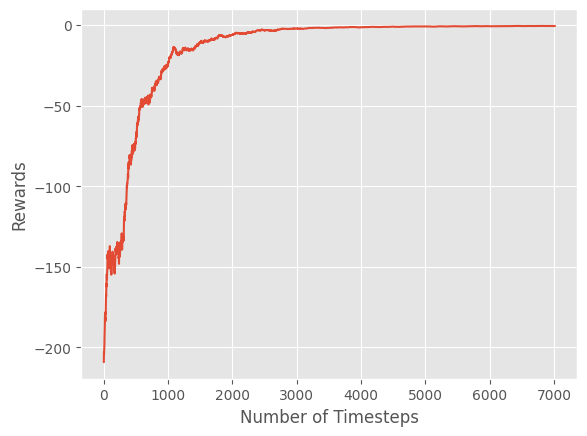

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
gazetools.plot_learning_curve()

In [29]:
import numpy as np
import pandas as pd

def eval_width(controller, width, episodes=100, max_steps=80, save_trace=None):
    """
    Run `episodes` episodes with a fixed target width and return:
    mean_steps, sem_steps, success, df
    """
    env = GazeModel()
    env.max_steps = max_steps
    env.TX.target_width = float(width)

    fname = save_trace if save_trace is not None else f"trace_w{width:.2f}.csv"
    df = gazetools.run_model(env, controller, episodes, fname)

    steps = df.groupby("episode").size() - 1

    def _hit(g):
        dx = g["fixate_x"].iloc[-1] - g["target_x"].iloc[-1]
        dy = g["fixate_y"].iloc[-1] - g["target_y"].iloc[-1]
        return np.hypot(dx, dy) < g["target_width"].iloc[-1] / 2

    success = df.groupby("episode").apply(_hit).mean()
    mean_steps = steps.mean()
    sem_steps  = steps.std(ddof=1) / np.sqrt(len(steps))
    return mean_steps, sem_steps, success, df

/tmp/ipython-input-2317722369.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success = df.groupby("episode").apply(_hit).mean()
/tmp/ipython-input-2317722369.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success = df.groupby("episode").apply(_hit).mean()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and schedu

,width,mean_steps,sem,success
0,0.08,2.533333,0.057897,1.0
1,0.12,2.333333,0.043214,1.0
2,0.16,2.300000,0.051040,1.0
3,0.20,2.283333,0.051834,1.0
4,0.24,2.133333,0.039132,1.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


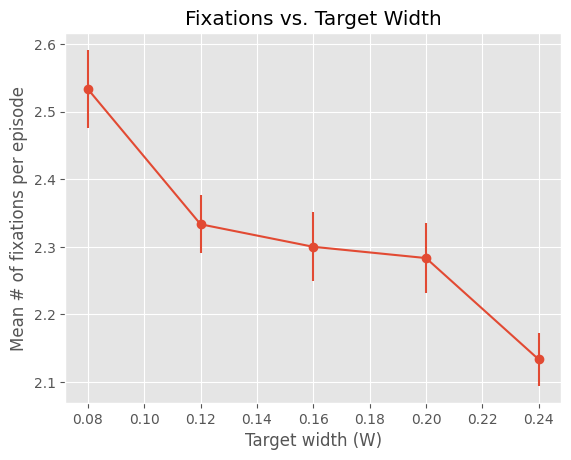

In [30]:
# Parameter
widths = [0.08, 0.12, 0.16, 0.20, 0.24]
episodes_per_width = 120
max_steps = 80

records = []
for w in widths:
    mean_s, sem_s, sr, df = eval_width(controller, w, episodes=episodes_per_width,
                                       max_steps=max_steps,
                                       save_trace=None)
    records.append({"width": w, "mean_steps": mean_s, "sem": sem_s, "success": sr})

summary = pd.DataFrame(records)
display(summary)

summary.to_csv("width_fixations_summary.csv", index=False)

plt.figure()
plt.errorbar(summary["width"], summary["mean_steps"], yerr=summary["sem"], fmt="o-")
plt.xlabel("Target width (W)")
plt.ylabel("Mean # of fixations per episode")
plt.title("Fixations vs. Target Width")
plt.grid(True)
plt.show()


,width,mean_time,sem,success
0,0.08,1.349419,0.226023,0.983333
1,0.12,0.966552,0.016355,1.000000
2,0.16,0.925314,0.014702,1.000000
3,0.20,0.920670,0.014489,1.000000
4,0.24,0.881634,0.012738,1.000000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


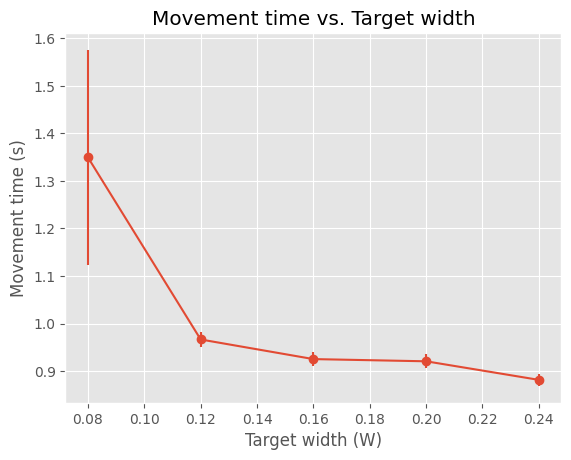

In [39]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def eval_width_time(model, width, episodes=100, max_steps=80):
    env = GazeModel()
    env.max_steps = max_steps
    env.TX.target_width = float(width)

    times, succ = [], 0
    for _ in range(episodes):
        obs, info = env.reset()
        term = trunc = False
        last_elapsed = 0.0
        while not (term or trunc):
            a, _ = model.predict(obs, deterministic=True)
            obs, r, term, trunc, info = env.step(a)
            last_elapsed = info["elapsed_time"]
        times.append(last_elapsed)
        succ += int(term)
    return np.array(times), succ/episodes

widths = [0.08, 0.12, 0.16, 0.20, 0.24]
episodes_per_width = 120
max_steps = 80

rows = []
for w in widths:
    T, sr = eval_width_time(controller, w, episodes=episodes_per_width, max_steps=max_steps)
    rows.append({"width": w, "mean_time": T.mean(), "sem": T.std(ddof=1)/np.sqrt(len(T)), "success": sr})
summary_t = pd.DataFrame(rows)
display(summary_t)
summary_t.to_csv("width_movement_time_summary.csv", index=False)

plt.figure()
plt.errorbar(summary_t["width"], summary_t["mean_time"], yerr=summary_t["sem"], fmt="o-")
plt.xlabel("Target width (W)")
plt.ylabel("Movement time (s)")
plt.title("Movement time vs. Target width")
plt.grid(True)
plt.show()


In [73]:
import numpy as np, pandas as pd

def eval_width_time_hits_only(model, width, episodes=120, max_steps=80):
    env = GazeModel(); env.max_steps = max_steps; env.TX.target_width = float(width)
    times = []
    for _ in range(episodes):
        obs, info = env.reset()
        term = trunc = False; last_t = 0.0
        while not (term or trunc):
            a, _ = model.predict(obs, deterministic=True)
            obs, r, term, trunc, info = env.step(a)
            last_t = info["elapsed_time"]
        if term:
            times.append(last_t)
    return np.array(times)

rows = []
for w in widths:
    T = eval_width_time_hits_only(controller, w, episodes=episodes_per_width, max_steps=max_steps)
    rows.append({"width": w, "mean_time": T.mean(), "sem": T.std(ddof=1)/np.sqrt(len(T)), "N_hit": len(T)})
df_hits = pd.DataFrame(rows)
display(df_hits)
df_hits.to_csv("width_movement_time_hits_only.csv", index=False)


,width,mean_time,sem,N_hit
0,0.08,1.011052,0.017174,120
1,0.12,0.999186,0.016770,120
2,0.16,0.939095,0.015517,120
3,0.20,0.936522,0.015422,120
4,0.24,0.920962,0.014125,120


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


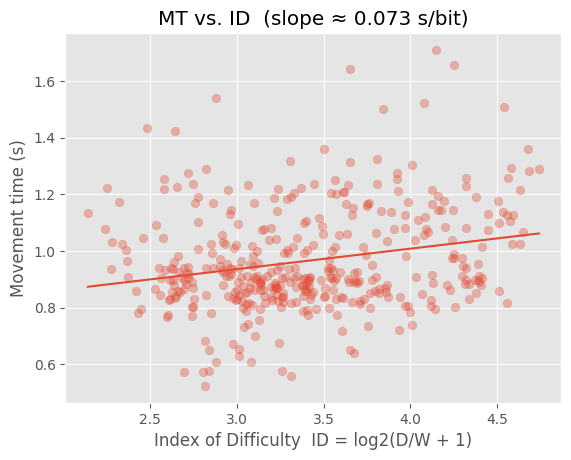

Slope=0.073 s/bit, Intercept=0.718, N=398


In [72]:
# Movement time vs. ID
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def eval_time_vs_ID(model, widths, episodes=80, max_steps=80):
    env = GazeModel(); env.max_steps = max_steps
    out = []
    for w in widths:
        env.TX.target_width = float(w)
        for _ in range(episodes):
            obs, info = env.reset()
            ID = info.get("ID", None)
            term = trunc = False; last_t = 0.0
            while not (term or trunc):
                a, _ = model.predict(obs, deterministic=True)
                obs, r, term, trunc, info = env.step(a)
                last_t = info["elapsed_time"]
            if term and ID is not None:
                out.append({"ID": ID, "MT": last_t})
    return pd.DataFrame(out)

df_mt = eval_time_vs_ID(controller, widths, episodes=80, max_steps=max_steps)
x, y = df_mt["ID"].to_numpy(), df_mt["MT"].to_numpy()
m, b = np.polyfit(x, y, 1); xp = np.linspace(x.min(), x.max(), 200)

plt.figure()
plt.scatter(x, y, alpha=0.35)
plt.plot(xp, m*xp + b)
plt.xlabel("Index of Difficulty  ID = log2(D/W + 1)")
plt.ylabel("Movement time (s)")
plt.title(f"MT vs. ID  (slope ≈ {m:.3f} s/bit)")
plt.grid(True)
plt.savefig("mt_vs_ID.png", dpi=160, bbox_inches="tight")
plt.show()
print(f"Slope={m:.3f} s/bit, Intercept={b:.3f}, N={len(df_mt)}")


### Increase timesteps

100,000 timesteps is not enough to train this model. Try doubling the number of timesteps and train again.

### Run the model for N trials
Run the trained model, save a trace of each episode to csv file, and animate the results.

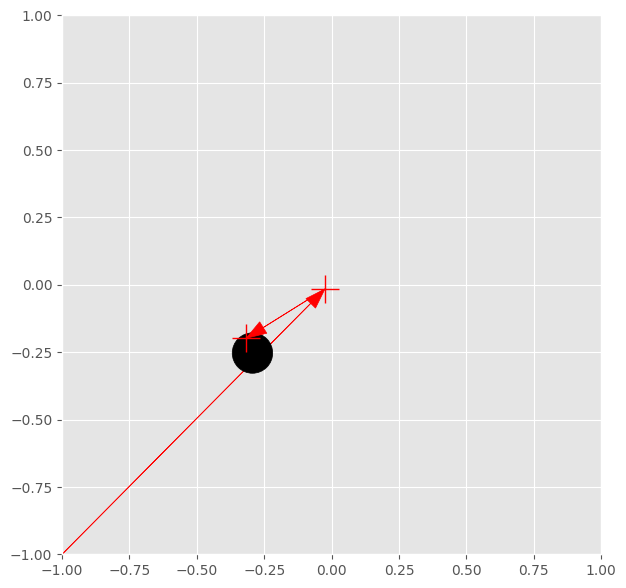

In [26]:
data = gazetools.run_model( model, controller, 100, 'behaviour_trace.csv' )

gazetools.animate_multiple_episodes(data, n=30)

### Exercises

- Rerun the model with different parameter settings. Start by trying a different target size. What is the impact on the behaviour?
- Discuss in groups how you would use the methods presented in the notebook to build a cognitive model of another task.

### Discussion

- The cognitive model that we have described above accurately predicts human gaze-based interaction performance (Chen et al., 2021).
- It is an example of a **computationally rational** cognitive model. This is because the behaviour is predicted from an approximately optimal policy given hypothesised bounds on cognition.
- It should be possible to find an approximately optimal policy using any reinforcement learning algorithm.  The only difference that the algorithm will make is to the efficiency with which solution is found.
- The separation of cognitive theory and reinforcement learning algorithm is achieved through the statement of the architecture as what is known as a belief-state Markov Decision Process (a **belief-state MDP**), which is a type of Partially Observable Markov Decision Process (POMDP).
- Using reinforcement learning (RL) to model cognition with the approximately optimal policy contrast does not model the human learning process. For work that does use RL to model human learning see Daw and Dayan (2008).
- A number of CHI papers have made use of this architecture. See Oulasvirta et al., 2022 for a review.
- An important issue concerns how model parameters are fitted to data. See Keuralinen et al., 2023.

### References
Chen, X., Acharya, A., Oulasvirta, A., & Howes, A. (2021, May). An adaptive model of gaze-based selection. In Proceedings of the 2021 CHI Conference on Human Factors in Computing Systems (pp. 1-11).

Chen, H., Chang, H. J., & Howes, A. (2021, May). Apparently Irrational Choice as Optimal Sequential Decision Making. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 35, No. 1, pp. 792-800).

Dayan, P., & Daw, N. D. (2008). Decision theory, reinforcement learning, and the brain. Cognitive, Affective, & Behavioral Neuroscience, 8(4), 429-453.

Oulasvirta, A., Jokinen, J. P., & Howes, A. (2022, April). Computational rationality as a theory of interaction. In Proceedings of the 2022 CHI Conference on Human Factors in Computing Systems (pp. 1-14).

Keurulainen, A., Westerlund, I. R., Keurulainen, O., & Howes, A. (2023, April). Amortised Experimental Design and Parameter Estimation for User Models of Pointing. In Proceedings of the 2023 CHI Conference on Human Factors in Computing Systems (pp. 1-17).